In [1]:
# some general packages
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # suppress all that TF output

# ML packages
import tensorflow as tf
tfk = tf.keras
from tensorflow.keras import initializers
import cymetric

# sage integration
from cymetric.sage.sagelib import prepare_toric_cy_data

# data generation
from cymetric.pointgen.pointgen_mathematica import PointGeneratorMathematica, PointGeneratorToricMathematica
from cymetric.pointgen.pointgen_toric import ToricPointGenerator
from cymetric.models.tfhelper import prepare_tf_basis
from cymetric.pointgen.nphelper import prepare_dataset, prepare_basis_pickle

# training
from cymetric.models.tfmodels import PhiFSModel, PhiFSModelToric
from cymetric.models.tfhelper import prepare_tf_basis
from cymetric.models.callbacks import RicciCallback, SigmaCallback, KaehlerCallback, AlphaCallback, VolkCallback, TransitionCallback
from cymetric.models.losses import sigma_loss
from cymetric.models.metrics import SigmaLoss, KaehlerLoss, TransitionLoss, VolkLoss, RicciLoss
from cymetric.models.measures import sigma_measure, transition_measure_loss, ricci_measure

# Example: Random KS model (we just take any with Picard Rank 2)

## Compute toric information

In [3]:
work_dir = "./ToricModel"
vertices = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [-1, -1, -1, 0], [2, 0, 0, -1]]  # P2 fibered over P2
polytope = LatticePolytope(vertices)
pConfig = PointConfiguration(polytope.points(), star=[0 for _ in range(len(vertices[0]))])
triangs = pConfig.restrict_to_connected_triangulations().restrict_to_fine_triangulations().restrict_to_regular_triangulations().restrict_to_star_triangulations([0 for _ in range(len(vertices[0]))]).triangulations_list()
triang = triangs[0]
tv_fan = triang.fan()
tv = ToricVariety(tv_fan)

toric_data = prepare_toric_cy_data(tv, os.path.join(work_dir, "toric_data.pickle"))
list(toric_data.keys())

['dim_cy',
 'vol_j_norm',
 'coeff_aK',
 'exp_aK',
 'exps_sections',
 'patch_masks',
 'glsm_charges',
 'non_ci_coeffs',
 'non_ci_exps',
 'triple']

## Generate points

In [4]:
num_pts       = int(100000)
precision     = int(10)
verbose       = int(1)
dim_cy        = toric_data['dim_cy']
monomials     = np.array(toric_data['exp_aK'])
coefficients  = np.array(toric_data['coeff_aK'])
sections      = toric_data['exps_sections']
non_ci_coeffs = toric_data['non_ci_coeffs']
non_ci_exps   = toric_data['non_ci_exps']
patch_masks   = toric_data['patch_masks']
glsm_charges  = toric_data['glsm_charges']
kmoduli       = np.ones(len(toric_data['exps_sections']))
dim_ps        = np.array([len(s)+1 for s in toric_data['exps_sections']])

In [5]:
mathematica_pointgen = PointGeneratorToricMathematica(dim_cy, monomials, coefficients, kmoduli, dim_ps, sections, non_ci_coeffs, non_ci_exps, patch_masks, glsm_charges, precision=precision, verbose=verbose)

In [6]:
prepare_dataset(mathematica_pointgen, num_pts, work_dir)
prepare_basis_pickle(mathematica_pointgen, work_dir)

WolframKernel-<tcp://127.0.0.1:43359>:INFO:Connected to logging socket: tcp://127.0.0.1:43359
WolframKernel-<tcp://127.0.0.1:43359>:DEBUG:Evaluating a new expression.
pointgenMathematica:DEBUG:Running with 15 Mathematica kernels.
pointgenMathematica:DEBUG:Initializing generation of 100000 points...
WolframKernel-<tcp://127.0.0.1:43359>:INFO:Number of points on CY from one ambient space intersection: 4
WolframKernel-<tcp://127.0.0.1:43359>:INFO:Now generating 100000 points...
WolframKernel-<tcp://127.0.0.1:43359>:INFO:Generated 0% of points
WolframKernel-<tcp://127.0.0.1:43359>:INFO:Generated 5% of points
WolframKernel-<tcp://127.0.0.1:43359>:INFO:Generated 10% of points
WolframKernel-<tcp://127.0.0.1:43359>:INFO:Generated 15% of points
WolframKernel-<tcp://127.0.0.1:43359>:INFO:Generated 20% of points
WolframKernel-<tcp://127.0.0.1:43359>:INFO:Generated 25% of points
WolframKernel-<tcp://127.0.0.1:43359>:INFO:Generated 30% of points
WolframKernel-<tcp://127.0.0.1:43359>:INFO:Generated 

0

## set up NN

In [7]:
tf.get_logger().setLevel('ERROR')
data = np.load(os.path.join(work_dir, 'dataset.npz'))
BASIS = prepare_tf_basis(np.load(os.path.join(work_dir, 'basis.pickle'), allow_pickle=True))
print([key for key in data])
print([key for key in BASIS])
kappa = 1/np.mean(data['y_train'][:,-2])
nfold = int(BASIS['NFOLD'].numpy().real)
print(1/kappa)

scb = SigmaCallback((data['X_val'], data['y_val']))
kcb = KaehlerCallback((data['X_val'], data['y_val']), data['val_pullbacks'])
tcb = TransitionCallback((data['X_val'], data['y_val']))
rcb = RicciCallback((data['X_val'], data['y_val']), data['val_pullbacks'])
volkck = VolkCallback((data['X_val'], data['y_val']))
cb_list = [scb, volkck]

cmetrics = [SigmaLoss(), VolkLoss()]
loss_fn = sigma_loss(kappa, nfold)


['X_train', 'y_train', 'X_val', 'y_val', 'val_pullbacks']
['DQDZB0', 'DQDZF0', 'QB0', 'QF0', 'NFOLD', 'AMBIENT', 'KMODULI', 'NHYPER']
4.805475030318229


In [8]:
nfold    = int(BASIS['NFOLD'].numpy().real)
amb      = [int(6)]
n_in     = int(12)
n_out    = int(1)
nHiddens = [int(64), int(64), int(64)]
acts     = ['gelu', 'gelu', 'gelu']
nEpochs  = int(50)
bSize    = int(64)
alpha    = [float(1.), float(1.), float(1.), float(1.), float(1.)]

In [9]:
model = tf.keras.Sequential()
model.add(tfk.Input(shape=(int(n_in))))
for nHidden, act in zip(nHiddens, acts):
    model.add(
        tfk.layers.Dense(
            nHidden, 
            activation=act,
            kernel_initializer=initializers.RandomNormal(stddev=float(0.01)),
            # bias_initializer=initializers.Zeros()
        )
    )
model.add(tfk.layers.Dense(n_out))

In [10]:
fs_model = PhiFSModelToric(model, BASIS, alpha=alpha, kappa=kappa, toric_data=toric_data)
fs_model.compile(custom_metrics=cmetrics, optimizer=tfk.optimizers.Adam(), loss=None, run_eagerly=True)  # uses custom loss function in training step, so the argument we pass here is ignored

## train NN

In [11]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
history = fs_model.fit(data['X_train'], data['y_train'], epochs=nEpochs, batch_size=bSize, verbose=1, callbacks=cb_list)

 - Sigma measure val:      0.4389
 - Volk val:               0.8398
Epoch 1/50


/home/ruehle/.local/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/PartitionedCall_4_grad/PartitionedCall:1", shape=(None,), dtype=int64), values=Tensor("gradients/PartitionedCall_4_grad/PartitionedCall:0", shape=(None, 6), dtype=complex64), dense_shape=Tensor("gradients/PartitionedCall_4_grad/PartitionedCall:2", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


1407/1407 [==============================] - ETA: 0s - sigma_loss: 0.3933 - volk_loss: 1.0401e-04 - Sigma measure val:      0.4054
 - Volk val:               0.7684
1407/1407 [==============================] - 1616s 1s/step - sigma_loss: 0.3933 - volk_loss: 1.0401e-04 - sigma_val: 0.4054 - volk_val: 0.7684
Epoch 2/50
1407/1407 [==============================] - ETA: 0s - sigma_loss: 0.3442 - volk_loss: 9.7084e-05 - Sigma measure val:      0.3723
 - Volk val:               0.7384
1407/1407 [==============================] - 1618s 1s/step - sigma_loss: 0.3442 - volk_loss: 9.7084e-05 - sigma_val: 0.3723 - volk_val: 0.7384
Epoch 3/50
1407/1407 [==============================] - ETA: 0s - sigma_loss: 0.3203 - volk_loss: 1.0126e-04 - Sigma measure val:      0.3693
 - Volk val:               0.7963
1407/1407 [==============================] - 1615s 1s/step - sigma_loss: 0.3203 - volk_loss: 1.0126e-04 - sigma_val: 0.3693 - volk_val: 0.7963
Epoch 4/50
1407/1407 [==============================] 

Epoch 27/50
1407/1407 [==============================] - ETA: 0s - sigma_loss: 0.2153 - volk_loss: 8.1612e-05 - Sigma measure val:      0.2781
 - Volk val:               0.8243
1407/1407 [==============================] - 1623s 1s/step - sigma_loss: 0.2153 - volk_loss: 8.1612e-05 - sigma_val: 0.2781 - volk_val: 0.8243
Epoch 28/50
1407/1407 [==============================] - ETA: 0s - sigma_loss: 0.2128 - volk_loss: 8.2396e-05 - Sigma measure val:      0.2695
 - Volk val:               0.8491
1407/1407 [==============================] - 1625s 1s/step - sigma_loss: 0.2128 - volk_loss: 8.2396e-05 - sigma_val: 0.2695 - volk_val: 0.8491
Epoch 29/50
1407/1407 [==============================] - ETA: 0s - sigma_loss: 0.2104 - volk_loss: 9.0114e-05 - Sigma measure val:      0.2701
 - Volk val:               0.8098
1407/1407 [==============================] - 1625s 1s/step - sigma_loss: 0.2104 - volk_loss: 9.0114e-05 - sigma_val: 0.2701 - volk_val: 0.8098
Epoch 30/50
1407/1407 [=================

In [15]:
hist=history.history
hist

{'sigma_loss': [0.39327535033226013,
  0.34415608644485474,
  0.32027673721313477,
  0.30799078941345215,
  0.29715245962142944,
  0.29023677110671997,
  0.28539857268333435,
  0.28173667192459106,
  0.27698296308517456,
  0.27339696884155273,
  0.2682029902935028,
  0.26533374190330505,
  0.26055434346199036,
  0.2579260468482971,
  0.2534025311470032,
  0.25103044509887695,
  0.24675031006336212,
  0.2434617131948471,
  0.24024458229541779,
  0.23668506741523743,
  0.23466360569000244,
  0.23134148120880127,
  0.22762566804885864,
  0.2248799204826355,
  0.22164849936962128,
  0.21910689771175385,
  0.21525701880455017,
  0.212821826338768,
  0.21038030087947845,
  0.20771688222885132,
  0.205640971660614,
  0.20348401367664337,
  0.20135284960269928,
  0.1992434561252594,
  0.1990731954574585,
  0.1966366469860077,
  0.19569697976112366,
  0.19367170333862305,
  0.1917411834001541,
  0.19161278009414673,
  0.19005213677883148,
  0.18827924132347107,
  0.1879751831293106,
  0.1860267

In [20]:
import pandas as pd
import seaborn as sns

In [22]:
hist_df = pd.DataFrame(hist)
hist_df

,sigma_loss,volk_loss,sigma_val,volk_val
0,0.393275,0.000104,0.405386,0.768381
1,0.344156,0.000097,0.372297,0.738400
2,0.320277,0.000101,0.369263,0.796268
3,0.307991,0.000103,0.359538,0.798212
4,0.297152,0.000092,0.346659,0.745706
5,0.290237,0.000099,0.346793,0.754981
6,0.285399,0.000092,0.337863,0.795899
7,0.281737,0.000092,0.332806,0.764415
8,0.276983,0.000098,0.327645,0.745929
9,0.273397,0.000106,0.327017,0.760195


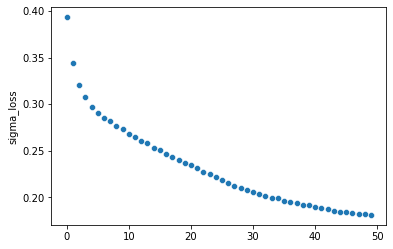

In [26]:
sns.scatterplot(x=list(range(len(hist_df))), y='sigma_loss', data=hist_df);

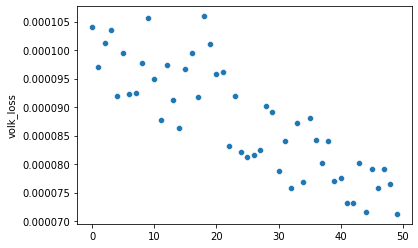

In [28]:
sns.scatterplot(x=list(range(len(hist_df))), y='volk_loss', data=hist_df);

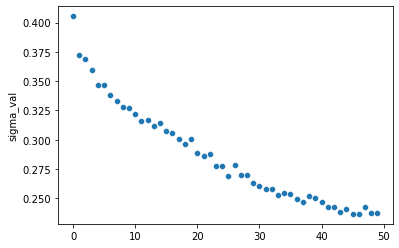

In [29]:
sns.scatterplot(x=list(range(len(hist_df))), y='sigma_val', data=hist_df);